In [1]:
import os
from scipy.ndimage import gaussian_filter1d
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from IPython.display import clear_output
import numpy as np

train_split = 0.70
test_split = 1 - train_split
val_split = 0.25

In [2]:
# create a list of all subfolders
actions = []
for file in os.listdir("Data"):
    if os.path.isdir(os.path.join("Data", file)):
        actions.append(file)

actions = np.array(actions)

label_map = {label:num for num, label in enumerate(actions)}
label_map

{'I (am)': 0, 'learn': 1, 'sign language': 2}

In [3]:
no_sequences = 100
sequence_length = 20
DATA_PATH = os.path.join('Data')

sequences, labels = [], []
for action in actions:
    for sequence in range(0, no_sequences):
        window = list(np.load(os.path.join(DATA_PATH, action, str(sequence) + ".npy")))
        sequences.append(window)
        labels.append(label_map[action])

assert len(labels) == len(actions) * no_sequences

In [4]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split)

In [5]:
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        if len(self.x) > 250:
            plt.plot(self.x[len(self.x)-250:], gaussian_filter1d(self.losses[len(self.x)-250:], 0.8), label="loss")
            plt.plot(self.x[len(self.x)-250:], gaussian_filter1d(self.val_losses[len(self.x)-250:], 0.8), label="val_loss")
        else:
            plt.plot(self.x, gaussian_filter1d(self.losses, 3), label="loss")
            plt.plot(self.x, gaussian_filter1d(self.val_losses, 3), label="val_loss")

        plt.legend()
        plt.show()

plot_losses = PlotLosses()
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)
early__stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, mode="min", min_delta=0.001, restore_best_weights=True)

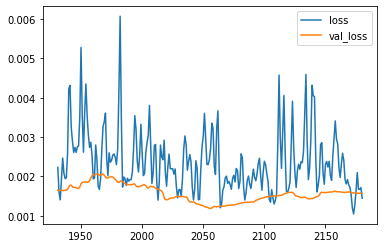

5/5 [==============================] - 1s 151ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 256)           349184    
                                                                 
 dropout (Dropout)           (None, 20, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0   

In [6]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, activation='selu', kernel_initializer='lecun_normal', input_shape=(20,84)))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=False, activation='selu', kernel_initializer='lecun_normal'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu', kernel_initializer='lecun_normal'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='selu', kernel_initializer='lecun_normal'))
model.add(Dense(actions.shape[0], activation='softmax'))

from tensorflow.keras.optimizers import SGD
opt = SGD(lr=0.0001)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])
model.fit(X_train, y_train, epochs=200000, callbacks=[plot_losses, tb_callback, early__stopping], verbose=1, validation_split=val_split)
model.summary()

In [7]:
y_pred = model.predict(X_test)

for i in range(len(y_pred)):
    print("Predicted:", actions[np.argmax(y_pred[i])], " "*(19 - len(actions[np.argmax(y_pred[i])])), "  actual: ", actions[np.argmax(y_test[i])], " "*(19 - len(actions[np.argmax(y_test[i])])),
          "Result:", "Correct" if np.argmax(y_pred[i]) == np.argmax(y_test[i]) else "Incorrect")

3/3 [==============================] - 1s 32ms/step
Predicted: I (am)                 actual:  I (am)               Result: Correct
Predicted: I (am)                 actual:  I (am)               Result: Correct
Predicted: learn                  actual:  learn                Result: Correct
Predicted: sign language          actual:  sign language        Result: Correct
Predicted: I (am)                 actual:  I (am)               Result: Correct
Predicted: learn                  actual:  learn                Result: Correct
Predicted: sign language          actual:  sign language        Result: Correct
Predicted: learn                  actual:  learn                Result: Correct
Predicted: sign language          actual:  sign language        Result: Correct
Predicted: learn                  actual:  learn                Result: Correct
Predicted: I (am)                 actual:  I (am)            

In [8]:
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm

array([[27,  0,  0],
       [ 0, 31,  0],
       [ 0,  0, 33]], dtype=int64)

In [9]:
# print accuracy
acc = (cm.diagonal().sum() / cm.sum()) * 100
print(f"Accuracy: {acc}%")

# print precision
precision = np.diag(cm) / np.sum(cm, axis=0)
print(f"Precision: {precision}")

# print recall
recall = np.diag(cm) / np.sum(cm, axis=1)
print(f"Recall: {recall}")

# print f1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f"F1 score: {f1_score}")

Accuracy: 100.0%
Precision: [1. 1. 1.]
Recall: [1. 1. 1.]
F1 score: [1. 1. 1.]


In [10]:
label_map

{'I (am)': 0, 'learn': 1, 'sign language': 2}

In [11]:
model.save('action.h5')
